# Panoptic Occupancy Prediction in BEV from a Single Camera (nuScenes-mini)

### **What you will build**
A model that takes a front-facing RGB camera image and predicts a panoptic representation in BEV:

- **Semantic BEV**: a 2D grid where each cell is a semantic class (empty / vehicle / pedestrian / bike-moto)

- **Instance centers**: a heatmap with peaks at each object’s BEV center

- **Offsets**: for each BEV cell belonging to an object instance, a vector pointing to its instance center

### **Why "Panoptic"?**
“Panoptic” means we want both semantics (“what is it?”) and instances (“which object is which?”). In 3D occupancy, this means identifying objects as separate instances in space (e.g., two different cars).

### **What is the key idea?**
We do not use true occupancy labels (those are expensive and not available in nuScenes in a simple form).
Instead, we create pseudo-labels from 3D bounding boxes:

- A BEV cell is “occupied by a vehicle” if it falls inside the BEV footprint of a vehicle’s 3D box.

- A BEV cell belongs to “instance k” if it falls inside the footprint of the k-th object box.

---

## 1) Setup: install libraries and mount dataset
We need:

- nuscenes-devkit: official API for reading nuScenes metadata and annotations

- pyquaternion: used by the devkit to represent rotations

- opencv-python-headless: sometimes required for image I/O utilities in headless environments

### 1.1 Install and load packages and download the nuScenes-mini dataset
Install and restart

In [ ]:
!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip -q install nuscenes-devkit pyquaternion opencv-python-headless


### 1.2 Data: provide nuScenes-mini
The downloaded data should look like this

### Explanation

- nuScenes expects a “root folder” containing sensor files and metadata tables.

- samples/ contains keyframe images.

- sweeps/ contains intermediate frames (we are not using them here, but included).

- maps/ contains map assets (not used in this notebook).

- v1.0-mini/ contains JSON tables: scenes, samples, annotations, etc.

In [1]:
DATA_ROOT = "./datasets/nuScenes/v1.0-mini/"  # change if needed
VERSION = "v1.0-mini"

import os
assert os.path.exists(DATA_ROOT), f"DATA_ROOT not found: {DATA_ROOT}"
for req in ["samples", "sweeps", "maps", VERSION]:
    assert os.path.exists(os.path.join(DATA_ROOT, req)), f"Missing {req} under {DATA_ROOT}"
print("nuScenes-mini folder structure looks OK.")

nuScenes-mini folder structure looks OK.


## 2) Imports & nuScenes API initialization
nuScenes is organized like a relational database:

- **scene**: a short driving sequence

- **sample**: a time step (frame) inside the scene

- **sample_data**: a sensor record for a sample (e.g., CAM_FRONT image file)

- **sample_annotation**: an object annotation (3D bounding box) tied to a sample

The devkit gives NuScenes(...) which loads these tables into memory and provides helper functions.

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion

nusc = NuScenes(version=VERSION, dataroot=DATA_ROOT, verbose=False)
print("Loaded:", VERSION)


Loaded: v1.0-mini


---

## 3) BEV grid definition
### **Theory: Why BEV?**

A BEV grid is a discretization of the ground plane around the ego vehicle. Many autonomous driving perception systems use BEV because:

- BEV aligns naturally with planning and control (meters in front/left).

- Sensor fusion (camera/LiDAR/radar) is often aggregated in ego coordinates.

- Spatial reasoning (e.g., “car in left lane”) is easier in BEV.

### **Coordinate convention (ego frame)**

- x: forward

- y: left

- (z: up) — but we are training only BEV (2D), not full 3D occupancy.

We define a rectangular region:

- x  ∈ [0, 40] meters forward

- y ∈ [-20, 20] meters lateral

Resolution:

- dx = dy = 0.8 m
So the grid is roughly 50×50 = 2500 cells.

### 3.1 Define BEV grid size
- X is the number of bins along forward axis.

- Y is the number of bins along lateral axis.

- We store as (Y,X) because 2D arrays are indexed [row, col], and we map:

    - row ↔ y index

    - col ↔ x index

In [3]:
GRID = dict(
    x_min=0.0,  x_max=40.0,  dx=0.8,
    y_min=-20.0, y_max=20.0, dy=0.8,
)

X = int((GRID["x_max"] - GRID["x_min"]) / GRID["dx"])
Y = int((GRID["y_max"] - GRID["y_min"]) / GRID["dy"])
print("BEV grid (Y,X) =", (Y, X))


BEV grid (Y,X) = (50, 50)


### 3.2 Precompute BEV cell centers

**Why centers?**
We need to decide whether each cell is inside a box footprint. The simplest rule is:

    A cell is occupied if its center point lies inside the rotated rectangle.

This is a standard rasterization technique (fast and stable).

In [4]:
def bev_centers(cfg):
    xs = np.linspace(cfg["x_min"] + cfg["dx"]/2, cfg["x_max"] - cfg["dx"]/2, X)
    ys = np.linspace(cfg["y_min"] + cfg["dy"]/2, cfg["y_max"] - cfg["dy"]/2, Y)
    yy, xx = np.meshgrid(ys, xs, indexing="ij")
    return np.stack([xx, yy], axis=-1)  # (Y,X,2) = [x,y]

BEV_CENTERS = bev_centers(GRID)
print("BEV_CENTERS:", BEV_CENTERS.shape)


BEV_CENTERS: (50, 50, 2)


---

## 4) Semantic classes and “panoptic” decomposition
### **Theory: Semantic vs instance**

- Semantic segmentation: label each location by class (car, pedestrian, …)

- Instance segmentation: assign a unique id to each object instance

Panoptic combines both:

- each pixel/cell has a semantic class

- and “thing” classes get instance ids (car #1, car #2)

In our BEV grid:

- sem[y,x] ∈ {0..3}

- inst_id[y,x] ∈ {0..N} where 0 means background (empty)

We also add:

- center heatmap: easier to detect object centers than bounding boxes from scratch

- offset field: assigns each pixel to an instance center (grouping mechanism)

### 4.1 Category mapping

nuScenes categories are fine-grained. For a coding lab, we collapse them:

- vehicles: all vehicle.* (cars, buses, trucks, etc.)

- pedestrians: human.pedestrian.*

- bicycle/motorcycle: contains those substrings

- everything else becomes background (0)

This reduces label complexity and stabilizes training.

In [ ]:
def category_to_class(name: str) -> int:
    name = name.lower()
    if name.startswith("vehicle."):
        return 1
    if name.startswith("human.pedestrian"):
        return 2
    if ("bicycle" in name) or ("motorcycle" in name):
        return 3
    return 0

NUM_CLASSES = 4  # 0 empty, 1 vehicle, 2 pedestrian, 3 bike/moto


### 4.2 Priority rule for overlaps

Overlaps can occur in BEV projections (especially if boxes overlap or due to discretization).
We enforce a deterministic rule:

- pedestrian highest (most safety-critical)

- then bike/motorcycle

- then vehicle

- then empty

In [ ]:
# Priority: pedestrian > bike/moto > vehicle > empty
PRIORITY = {0: 0, 1: 1, 3: 2, 2: 3}

---

## 5) Geometry: 3D boxes to BEV footprints
### **Theory: Coordinate frames**

nuScenes stores annotations in a global coordinate frame.
But BEV grids for perception are typically defined in the ego vehicle frame at that timestamp.

So we must do:

1. Get ego pose (translation + rotation) at CAM_FRONT timestamp

2. Transform each box from global → ego:

    - subtract ego translation

    - rotate by inverse ego rotation

Then each box in ego frame has:
- center coordinates in ego frame
- orientation relative to ego frame

Now we can rasterize its BEV footprint.

### 5.1 Get boxes in ego frame
- ego_pose is the vehicle pose in global coordinates.

- box.translate(-ego_t) shifts the box center to the ego origin.

- box.rotate(ego_q.inverse) rotates the box into ego orientation.

In [6]:
def get_boxes_ego(sample_token: str):
    sample = nusc.get("sample", sample_token)

    cam_token = sample["data"]["CAM_FRONT"]
    sd = nusc.get("sample_data", cam_token)
    ego = nusc.get("ego_pose", sd["ego_pose_token"])

    ego_t = np.array(ego["translation"], dtype=np.float32)
    ego_q = Quaternion(ego["rotation"])

    boxes = []
    for ann_tok in sample["anns"]:
        ann = nusc.get("sample_annotation", ann_tok)
        cls = category_to_class(ann["category_name"])
        if cls == 0:
            continue

        box = Box(
            center=ann["translation"],
            size=ann["size"],
            orientation=Quaternion(ann["rotation"]),
        )

        # global -> ego
        box.translate(-ego_t)
        box.rotate(ego_q.inverse)

        boxes.append((box, cls))
    return boxes


### 5.2 Rasterize a rotated box into BEV mask
**Key concept:** If we rotate points into the box’s local coordinates, the box becomes axis-aligned.

Steps:

1. Take each BEV cell center p and shift by box center (so box center is origin).

2. Rotate p by inverse box rotation → into box coordinates.

3. In box coordinates, a point is inside if:

    - |x| <= length/2

    - |y| <= width/2

Because we use only x,y, this is footprint rasterization.

In [7]:
def box_to_bev_mask(box: Box):
    # nuScenes box.wlh = (width, length, height)
    w, l, _ = box.wlh

    # transform BEV points into box local frame using inverse rotation
    R_inv = box.orientation.inverse.rotation_matrix[:2, :2].astype(np.float32)

    p = BEV_CENTERS - box.center[:2]          # (Y,X,2)
    p = p.reshape(-1, 2).astype(np.float32)   # (N,2)

    p_local = (R_inv @ p.T).T                 # (N,2)

    inside = (np.abs(p_local[:, 0]) <= l/2) & (np.abs(p_local[:, 1]) <= w/2)
    return inside.reshape(Y, X)


---

## 6) Panoptic targets: semantic + instance + center + offset
### **Theory: Center + Offset panoptic representation**

Instead of directly predicting instance ids (which is hard and variable-size), we predict:

- a center heatmap: peaks indicate instance centers

- an offset vector at each pixel: tells which center it belongs to

Then we reconstruct instances by clustering pixels that vote for the same center.

This has major advantages:

- Fixed output size

- Differentiable supervision

- Handles variable number of instances

### 6.1 Helpers: BEV indexing + Gaussian center drawing
- xy_to_bev_index converts meters → grid cell index.

- draw_gaussian creates a soft peak around the center.

    - A Gaussian is preferred over a single 1-hot pixel because:

        - It provides smoother gradients (easier optimization)

        - It is robust to discretization error

- We use max to handle overlapping Gaussians.

In [8]:
def xy_to_bev_index(x, y, cfg):
    ix = int((x - cfg["x_min"]) / cfg["dx"])
    iy = int((y - cfg["y_min"]) / cfg["dy"])
    if 0 <= ix < X and 0 <= iy < Y:
        return iy, ix  # (row=y, col=x)
    return None

def draw_gaussian(heatmap, cy, cx, sigma=2.0):
    yy = np.arange(heatmap.shape[0])[:, None]
    xx = np.arange(heatmap.shape[1])[None, :]
    g = np.exp(-((yy - cy)**2 + (xx - cx)**2) / (2 * sigma**2))
    heatmap[:] = np.maximum(heatmap, g)


### 6.2 Build panoptic targets
This is the core supervision creation.

- sem is semantic label per cell.

- inst_id assigns a unique instance id per object footprint.

- center_hm puts a Gaussian at each instance center.

- offset is defined only on instance pixels; background offsets are meaningless.

- valid_inst indicates which cells have valid offset supervision.

In [9]:
def build_panoptic_bev(sample_token: str, cfg):
    sem = np.zeros((Y, X), dtype=np.int64)
    sem_pr = np.zeros((Y, X), dtype=np.int64)

    inst_id = np.zeros((Y, X), dtype=np.int64)
    center_hm = np.zeros((Y, X), dtype=np.float32)
    offset = np.zeros((2, Y, X), dtype=np.float32)      # (dy, dx)
    valid_inst = np.zeros((Y, X), dtype=np.float32)

    boxes = get_boxes_ego(sample_token)

    next_inst = 1
    for box, cls in boxes:
        mask = box_to_bev_mask(box)
        if mask.sum() < 5:
            continue

        # Semantic overwrite by priority
        update_sem = mask & (PRIORITY[cls] > sem_pr)
        sem[update_sem] = cls
        sem_pr[update_sem] = PRIORITY[cls]

        # Instance ids: for teaching simplicity, do not overwrite existing instances
        write = mask & (inst_id == 0)
        if write.sum() < 5:
            continue

        inst_id[write] = next_inst

        # Center index from box center
        c = xy_to_bev_index(box.center[0], box.center[1], cfg)
        if c is None:
            continue
        cy, cx = c

        # Center heatmap
        draw_gaussian(center_hm, cy, cx, sigma=2.0)

        # Offsets for instance pixels: vector to center (dy, dx)
        ys, xs = np.where(write)
        offset[0, ys, xs] = (cy - ys).astype(np.float32)  # dy
        offset[1, ys, xs] = (cx - xs).astype(np.float32)  # dx
        valid_inst[ys, xs] = 1.0

        next_inst += 1

    return sem, center_hm, offset, valid_inst


---

## 7) Frustum mask supervision
### **Theory: observability from a single camera**

Your BEV grid includes areas the camera cannot see (behind the vehicle, extreme sides).
If you supervise those areas, training becomes inconsistent:

- label exists in BEV, but there is no visual evidence in the image.

**Solution**: apply a mask so loss is computed only in a forward wedge.

This is a simplified frustum. It’s not exact projection geometry, but it is effective and easy to teach.

### 7.1 Frustum mask
Condition: |y| < k*x

- near the car (small x), lateral range is small

- farther away (large x), lateral range increases

In [10]:
def bev_frustum_mask(cfg, k=0.6):
    xs = np.linspace(cfg["x_min"], cfg["x_max"], X)
    ys = np.linspace(cfg["y_min"], cfg["y_max"], Y)
    yy, xx = np.meshgrid(ys, xs, indexing="ij")
    mask = (xx > 0) & (np.abs(yy) < k * xx)
    return mask.astype(np.float32)

FRUSTUM = torch.from_numpy(bev_frustum_mask(GRID, k=0.6))  # (Y,X)
print("Frustum coverage:", float(FRUSTUM.mean()))


Frustum coverage: 0.5735999941825867


## 8) Dataset and loaders

We build a PyTorch Dataset that returns (image, panoptic targets).
This includes computing pseudo-labels on the fly.

For speed in a real class, you may cache labels to disk, but on nuScenes-mini this is usually fine.

### 8.1 Collect sample tokens

- nuScenes-mini has few scenes; using max_scenes=1 keeps the run fast and deterministic.

- We shuffle and split into train/val.

In [12]:
def collect_tokens(max_scenes=1):
    tokens = []
    for si in range(min(max_scenes, len(nusc.scene))):
        scene = nusc.scene[si]
        tok = scene["first_sample_token"]
        while tok:
            tokens.append(tok)
            tok = nusc.get("sample", tok)["next"]
    return tokens

tokens = collect_tokens(max_scenes=1)  # keep it small for class
np.random.seed(0)
np.random.shuffle(tokens)

n_train = int(0.8 * len(tokens))
train_tokens = tokens[:n_train]
val_tokens = tokens[n_train:]

print("Total / Train / Val:", len(tokens), len(train_tokens), len(val_tokens))


Total / Train / Val: 39 31 8


### 8.2 Dataset class
- img_t: normalized RGB tensor

- sem: class labels for BEV cells

- center_hm: float heatmap in [0,1]

- offset: dy/dx vectors

- valid_inst: mask for offset loss

In [13]:
class NuScenesPanopticBEVDataset(Dataset):
    def __init__(self, tokens, grid_cfg, image_size=(256, 128)):
        self.tokens = tokens
        self.grid_cfg = grid_cfg
        self.image_size = image_size  # (W,H)

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, i):
        tok = self.tokens[i]
        sample = nusc.get("sample", tok)

        cam = sample["data"]["CAM_FRONT"]
        sd = nusc.get("sample_data", cam)
        img_path = os.path.join(DATA_ROOT, sd["filename"])

        img = Image.open(img_path).convert("RGB")
        img = img.resize(self.image_size)
        img_t = torch.from_numpy(np.array(img)).permute(2,0,1).float() / 255.0

        sem, center_hm, offset, valid_inst = build_panoptic_bev(tok, self.grid_cfg)

        return (
            img_t,
            torch.from_numpy(sem).long(),
            torch.from_numpy(center_hm).float(),
            torch.from_numpy(offset).float(),
            torch.from_numpy(valid_inst).float(),
        )

train_ds = NuScenesPanopticBEVDataset(train_tokens, GRID)
val_ds   = NuScenesPanopticBEVDataset(val_tokens, GRID)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)


---

## 9) Model: encoder → BEV → three heads
### **Theory: Why adaptive pooling to BEV?**

We are not doing explicit camera geometry / depth lifting (like LSS).
For a TA lab, we use an intentionally simplified mapping:

1. CNN extracts image features

2. We resize features to (Y,X) using adaptive pooling

3. A small BEV refinement block learns spatial smoothing

4. Heads output:

    - semantic logits (C channels)

    - center heatmap (1 channel)

    - offsets (2 channels)

This is not SOTA geometry, but it is perfect for teaching multi-head panoptic training.

### 9.1 Model definition
- enc: reduces image resolution while increasing channels

- adaptive_avg_pool2d(f, (Y,X)): produces a BEV-shaped feature map

- sem_head: per-cell classification

- center_head: regression to heatmap values

- offset_head: dy/dx vector regression

In [14]:
class TinyPanopticBEVNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(inplace=True),
        )
        self.bev_refine = nn.Sequential(
            nn.Conv2d(128, 64, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(inplace=True),
        )
        self.sem_head = nn.Conv2d(64, num_classes, 1)
        self.center_head = nn.Conv2d(64, 1, 1)
        self.offset_head = nn.Conv2d(64, 2, 1)

    def forward(self, x):
        f = self.enc(x)                          # (B,128,H',W')
        f = F.adaptive_avg_pool2d(f, (Y, X))     # (B,128,Y,X)
        f = self.bev_refine(f)                   # (B,64,Y,X)
        sem = self.sem_head(f)                   # (B,C,Y,X)
        center = self.center_head(f)             # (B,1,Y,X)
        offset = self.offset_head(f)             # (B,2,Y,X)
        return sem, center, offset


---

## 10) Losses and optimization
### **Theory: multi-task learning**

We have 3 tasks:

1. semantic classification (CE)

2. center heatmap regression (MSE)

3. offset regression (L1)

Total loss is weighted sum:

𝐿 = 𝐿𝑠𝑒𝑚+𝜆𝑐𝐿𝑐𝑒𝑛𝑡𝑒𝑟+𝜆𝑜𝐿𝑜𝑓𝑓𝑠𝑒𝑡

**Why weighted semantic CE?**

Empty dominates → without class weights, model predicts empty everywhere.

**Why offset mask?**

Offsets are undefined for background → we only supervise where valid_inst=1.

**Why frustum mask?**

Only supervise regions consistent with camera evidence.

### 10.1 Setup training objects

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyPanopticBEVNet().to(device)

FRUSTUM_T = FRUSTUM.to(device)  # (Y,X)

# Strongly down-weight empty
sem_weights = torch.tensor([0.02, 1.0, 2.0, 1.5], dtype=torch.float32, device=device)
sem_ce = nn.CrossEntropyLoss(weight=sem_weights, reduction="none")  # per-pixel CE

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

print("Device:", device)
print("Params:", sum(p.numel() for p in model.parameters()))


Device: cuda
Params: 175815


---

## 11) Training / evaluation loops

We implement:

- reduce_masked: sums loss only inside frustum and normalizes

- train_epoch: forward → losses → backprop

- eval_epoch: compute validation loss + mIoU (ignoring empty)

### 11.1 IoU metric

In [16]:
def compute_iou(pred, target, num_classes=NUM_CLASSES, ignore_class=0):
    ious = []
    for c in range(num_classes):
        if ignore_class is not None and c == ignore_class:
            continue
        p = (pred == c)
        t = (target == c)
        inter = (p & t).sum().item()
        union = (p | t).sum().item()
        if union == 0:
            continue
        ious.append(inter / union)
    return float(np.mean(ious)) if ious else 0.0


### 11.2 Train/eval epoch functions
- We compute semantic CE everywhere, then mask by frustum.

- Center loss trains the model to predict peaks at object centers.

- Offset loss trains the vector field used for grouping.

- w_offset is lower because offsets can be numerically larger and dominate otherwise.

In [17]:
def reduce_masked(loss_map, mask, eps=1e-6):
    # loss_map: (B,Y,X), mask: (Y,X)
    den = mask.sum() * loss_map.shape[0] + eps
    return (loss_map * mask[None]).sum() / den

def train_epoch(loader, w_center=1.0, w_offset=0.1):
    model.train()
    total = 0.0
    for img, sem_gt, center_gt, offset_gt, valid_inst in loader:
        img = img.to(device)
        sem_gt = sem_gt.to(device)
        center_gt = center_gt.to(device)
        offset_gt = offset_gt.to(device)
        valid_inst = valid_inst.to(device)

        sem_logits, center_pred, offset_pred = model(img)

        # --- semantic loss ---
        sem_loss_map = sem_ce(sem_logits, sem_gt)  # (B,Y,X)
        sem_loss = reduce_masked(sem_loss_map, FRUSTUM_T)

        # --- center heatmap loss (MSE) ---
        center_pred = center_pred.squeeze(1)  # (B,Y,X)
        center_loss_map = (center_pred - center_gt) ** 2
        center_loss = reduce_masked(center_loss_map, FRUSTUM_T)

        # --- offset loss (L1) only where instance pixels exist ---
        # offset_pred/gt: (B,2,Y,X) -> L1 per pixel
        offset_l1 = torch.abs(offset_pred - offset_gt).sum(dim=1)  # (B,Y,X)

        # valid pixels = instance pixels AND in frustum
        valid = valid_inst * FRUSTUM_T[None]  # (B,Y,X)
        den = valid.sum() + 1e-6
        offset_loss = (offset_l1 * valid).sum() / den

        loss = sem_loss + w_center * center_loss + w_offset * offset_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()
    return total / max(1, len(loader))

@torch.no_grad()
def eval_epoch(loader, w_center=1.0, w_offset=0.1):
    model.eval()
    total_loss, total_iou = 0.0, 0.0
    for img, sem_gt, center_gt, offset_gt, valid_inst in loader:
        img = img.to(device)
        sem_gt = sem_gt.to(device)
        center_gt = center_gt.to(device)
        offset_gt = offset_gt.to(device)
        valid_inst = valid_inst.to(device)

        sem_logits, center_pred, offset_pred = model(img)

        sem_loss_map = sem_ce(sem_logits, sem_gt)
        sem_loss = reduce_masked(sem_loss_map, FRUSTUM_T)

        center_pred = center_pred.squeeze(1)
        center_loss_map = (center_pred - center_gt) ** 2
        center_loss = reduce_masked(center_loss_map, FRUSTUM_T)

        offset_l1 = torch.abs(offset_pred - offset_gt).sum(dim=1)
        valid = valid_inst * FRUSTUM_T[None]
        den = valid.sum() + 1e-6
        offset_loss = (offset_l1 * valid).sum() / den

        loss = sem_loss + w_center * center_loss + w_offset * offset_loss

        pred_sem = sem_logits.argmax(dim=1)  # (B,Y,X)
        iou = compute_iou(pred_sem.flatten(), sem_gt.flatten(), ignore_class=0)

        total_loss += loss.item()
        total_iou += iou

    return total_loss / max(1, len(loader)), total_iou / max(1, len(loader))


### 11.4 Run training

In [18]:
EPOCHS = 1000
for e in range(1, EPOCHS + 1):
    tr_loss = train_epoch(train_loader, w_center=1.0, w_offset=0.1)
    va_loss, va_iou = eval_epoch(val_loader, w_center=1.0, w_offset=0.1)
    print(f"Epoch {e:02d} | train loss {tr_loss:.4f} | val loss {va_loss:.4f} | val mIoU(no-empty) {va_iou:.3f}")


Epoch 01 | train loss 0.3697 | val loss 0.3815 | val mIoU(no-empty) 0.000
Epoch 02 | train loss 0.3644 | val loss 0.3805 | val mIoU(no-empty) 0.000
Epoch 03 | train loss 0.3634 | val loss 0.3789 | val mIoU(no-empty) 0.026
Epoch 04 | train loss 0.3565 | val loss 0.3762 | val mIoU(no-empty) 0.016
Epoch 05 | train loss 0.3588 | val loss 0.3714 | val mIoU(no-empty) 0.016
Epoch 06 | train loss 0.3582 | val loss 0.3610 | val mIoU(no-empty) 0.032
Epoch 07 | train loss 0.3477 | val loss 0.3555 | val mIoU(no-empty) 0.032
Epoch 08 | train loss 0.3387 | val loss 0.3548 | val mIoU(no-empty) 0.032
Epoch 09 | train loss 0.3404 | val loss 0.3520 | val mIoU(no-empty) 0.032
Epoch 10 | train loss 0.3251 | val loss 0.3486 | val mIoU(no-empty) 0.032
Epoch 11 | train loss 0.3269 | val loss 0.3469 | val mIoU(no-empty) 0.032
Epoch 12 | train loss 0.3313 | val loss 0.3440 | val mIoU(no-empty) 0.032
Epoch 13 | train loss 0.3260 | val loss 0.3415 | val mIoU(no-empty) 0.032
Epoch 14 | train loss 0.3183 | val los

---

## 12) Visualization and panoptic reconstruction
### **Theory: How to get instances from center+offset**

We have:

- center heatmap: likely centers

- offsets: each pixel votes for a center location

Algorithm:

1. Extract center peaks by threshold + non-maximum suppression (NMS)

2. For each pixel, compute predicted center coordinate:

    𝑐^(𝑝)=𝑝+Δ(𝑝)

3. Assign pixel to nearest detected center (within a radius)

This is a simplified decoder, but demonstrates the concept clearly.

### 12.1 Plot helpers

In [36]:
def show_img(img_t, title="image"):
    plt.figure(figsize=(10,4))
    plt.imshow(img_t.permute(1,2,0))
    plt.title(title)
    plt.axis("off")
    plt.show()

def show_map(m, title="map", cmap=None, vmin=0.5, vmax=None):
    plt.figure(figsize=(5,5))
    plt.imshow(m, origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis("off")
    plt.show()


### 12.2 Peak finding + instance assignment

In [20]:
def find_peaks(center_map, thr=0.5, max_peaks=30, nms=3):
    """
    center_map: (Y,X) numpy float
    Returns list of (y,x) peaks
    """
    m = center_map.copy()
    peaks = []
    for _ in range(max_peaks):
        y, x = np.unravel_index(np.argmax(m), m.shape)
        if m[y, x] < thr:
            break
        peaks.append((y, x))
        # NMS: zero out local neighborhood
        y0, y1 = max(0, y-nms), min(m.shape[0], y+nms+1)
        x0, x1 = max(0, x-nms), min(m.shape[1], x+nms+1)
        m[y0:y1, x0:x1] = 0.0
    return peaks

def offsets_to_instances(center_map, offset_map, sem_map, thr=0.5, radius=6):
    """
    center_map: (Y,X) float
    offset_map: (2,Y,X) float, (dy,dx)
    sem_map: (Y,X) int semantic prediction
    """
    peaks = find_peaks(center_map, thr=thr, max_peaks=30, nms=3)
    if len(peaks) == 0:
        return np.zeros_like(sem_map), peaks

    peaks_arr = np.array(peaks, dtype=np.float32)  # (K,2) y,x

    Y_, X_ = sem_map.shape
    yy, xx = np.meshgrid(np.arange(Y_), np.arange(X_), indexing="ij")

    # vote predicted center per pixel
    cy = yy + offset_map[0]
    cx = xx + offset_map[1]
    votes = np.stack([cy, cx], axis=-1).reshape(-1, 2)  # (N,2)

    # assign each pixel to nearest peak
    # (N,K) distances
    d2 = ((votes[:, None, :] - peaks_arr[None, :, :]) ** 2).sum(axis=-1)
    nn = np.argmin(d2, axis=1)
    min_d = np.sqrt(np.min(d2, axis=1))

    inst = np.zeros((Y_, X_), dtype=np.int64)
    inst_flat = inst.reshape(-1)

    # only assign non-empty semantic pixels
    nonempty = (sem_map.reshape(-1) > 0)

    # within radius and nonempty
    ok = (min_d <= radius) & nonempty
    inst_flat[ok] = nn[ok] + 1  # instance ids start at 1

    return inst, peaks


### 12.3 Qualitative results on one val sample

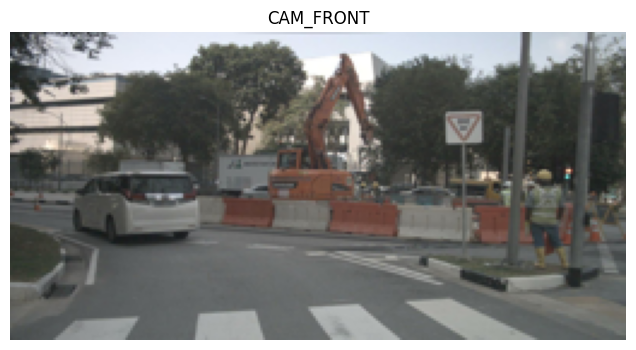

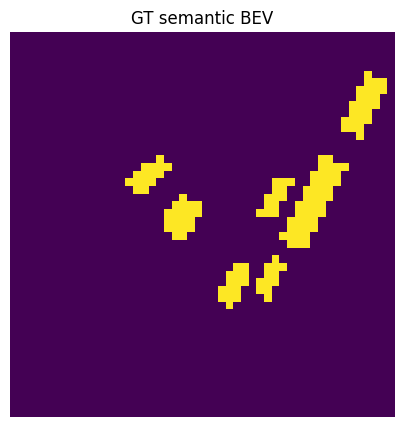

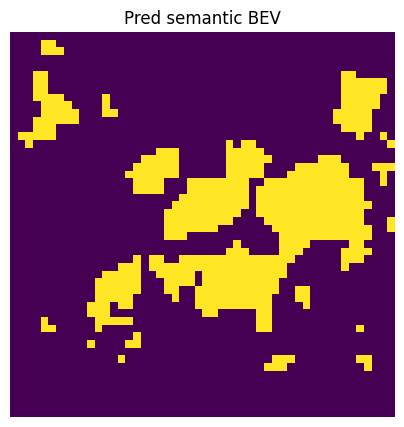

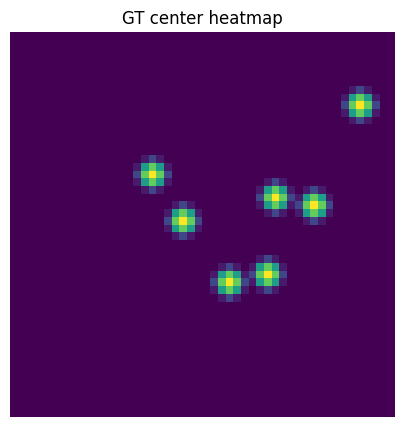

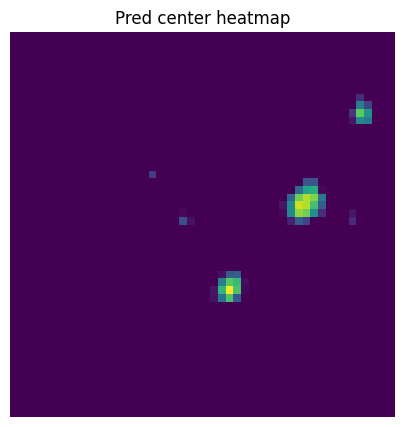

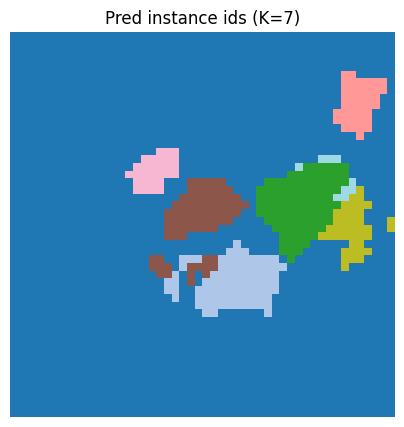

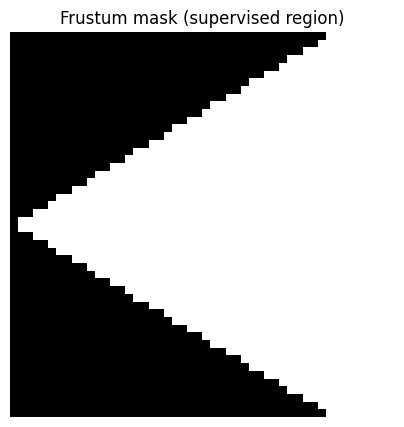

In [70]:
model.eval()
img, sem_gt, center_gt, offset_gt, valid_inst = train_ds[16]

with torch.no_grad():
    sem_logits, center_pred, offset_pred = model(img.unsqueeze(0).to(device))
    sem_pred = sem_logits.argmax(dim=1)[0].cpu().numpy()
    center_pred = center_pred[0,0].cpu().numpy()
    offset_pred = offset_pred[0].cpu().numpy()

show_img(img, "CAM_FRONT")

show_map(sem_gt.numpy(), "GT semantic BEV")
show_map(sem_pred, "Pred semantic BEV")

show_map(center_gt.numpy(), "GT center heatmap", cmap="viridis")
show_map(center_pred, "Pred center heatmap", cmap="viridis")

inst_pred, peaks = offsets_to_instances(center_pred, offset_pred, sem_pred, thr=0.4, radius=6)
show_map(inst_pred, f"Pred instance ids (K={len(peaks)})", cmap="tab20")

show_map(FRUSTUM.numpy(), "Frustum mask (supervised region)", cmap="gray")


### 12.4 Offset vector field quiver plot

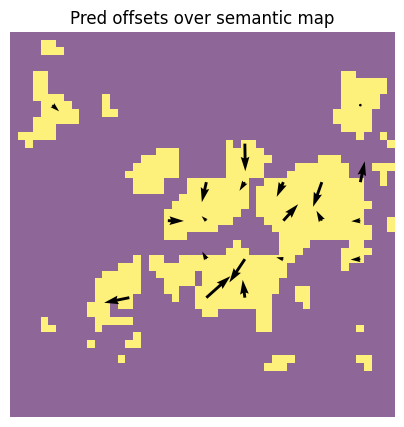

In [71]:
def show_offset_quiver(offset_map, sem_map, step=4, title="Offsets (dy,dx)"):
    # offset_map: (2,Y,X), sem_map: (Y,X)
    yy, xx = np.meshgrid(np.arange(Y), np.arange(X), indexing="ij")
    mask = (sem_map > 0)
    # subsample
    sel = mask & ((yy % step == 0) & (xx % step == 0))
    ys, xs = np.where(sel)
    if len(ys) == 0:
        print("No non-empty pixels for quiver.")
        return

    dy = offset_map[0, ys, xs]
    dx = offset_map[1, ys, xs]

    plt.figure(figsize=(5,5))
    plt.imshow(sem_map, origin="lower", alpha=0.6)
    plt.quiver(xs, ys, dx, dy, angles="xy", scale_units="xy", scale=1.0)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_offset_quiver(offset_pred, sem_pred, step=5, title="Pred offsets over semantic map")


## 13) Theory recap
**Why center + offset works**

- The network learns:

    - where object centers are

    - how pixels should group to the correct center

- This avoids predicting a variable number of instances directly.

**Why frustum masking is critical for monocular BEV**

- Without it, you supervise regions without visual evidence → inconsistent gradients.

**Why semantic weighting is critical**

- Empty dominates BEV grids.

- Without weighting, the trivial solution is always “empty.”

**What is missing compared to real panoptic occupancy**

- We use box footprints (proxy occupancy), not true occupancy

- No “stuff” classes (road) unless you add map supervision